In [13]:
# imports
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from tqdm.auto import tqdm
# plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS,InducedOperatorModel,SharedOperatorPDEModel
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM
from Optimizers.solvers_base import *


In [14]:
m = 20
obs_pts = 2
run = 10

kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = 2024
                                    )
                                    )
# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],15,15)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(run)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
P_model = InducedOperatorModel(grid_features_u_init,k_P)
num_P_params = len(grid_features_u_init)

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = num_P_params
)


In [15]:
u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )


  0%|          | 1/501 [00:13<1:52:55, 13.55s/it]

Iteration 0, loss = 0.5188, gradnorm = 18.11, alpha = 0.08333, improvement_ratio = 1.0


  0%|          | 2/501 [00:13<48:06,  5.78s/it]  

Iteration 1, loss = 0.3183, gradnorm = 0.3749, alpha = 0.06944, improvement_ratio = 1.005


  1%|          | 3/501 [00:14<27:23,  3.30s/it]

Iteration 2, loss = 0.2568, gradnorm = 0.09701, alpha = 0.05787, improvement_ratio = 1.005


  1%|          | 4/501 [00:14<17:40,  2.13s/it]

Iteration 3, loss = 0.2183, gradnorm = 0.05952, alpha = 0.04823, improvement_ratio = 1.004


  1%|          | 5/501 [00:14<12:18,  1.49s/it]

Iteration 4, loss = 0.1912, gradnorm = 0.04444, alpha = 0.04019, improvement_ratio = 1.004


  1%|          | 6/501 [00:15<09:05,  1.10s/it]

Iteration 5, loss = 0.1715, gradnorm = 0.03437, alpha = 0.03349, improvement_ratio = 1.004


 20%|██        | 101/501 [00:48<02:21,  2.83it/s]

Iteration 100, loss = 5.384e-05, gradnorm = 7.912e-06, alpha = 4.327e-09, improvement_ratio = 1.142


 21%|██        | 106/501 [00:50<03:08,  2.10it/s]


In [16]:
all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])


In [17]:
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))
table_u_errors(xy_fine,(u_model,)*m,u_sol,list(map(jax.vmap,u_true_functions)),all_u_params_init)

,Percent error 1 step,Percent error 2 step (at init)
0,0.388817,9.199330
1,0.456131,14.781289
2,0.498754,5.407096
3,0.503051,9.440026
4,0.181776,2.178283
5,0.766033,7.505966
6,0.293882,4.300273
7,0.511932,11.916686
8,0.363567,2.263050
9,0.594199,3.299292


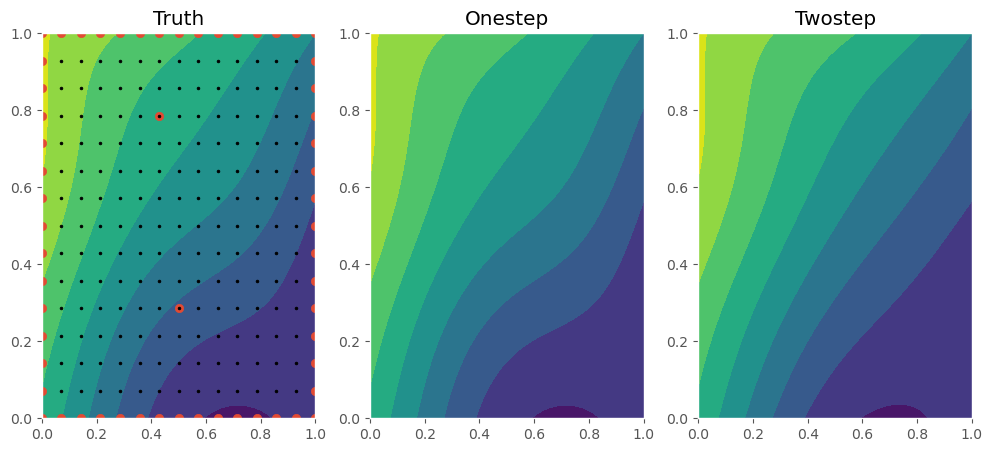

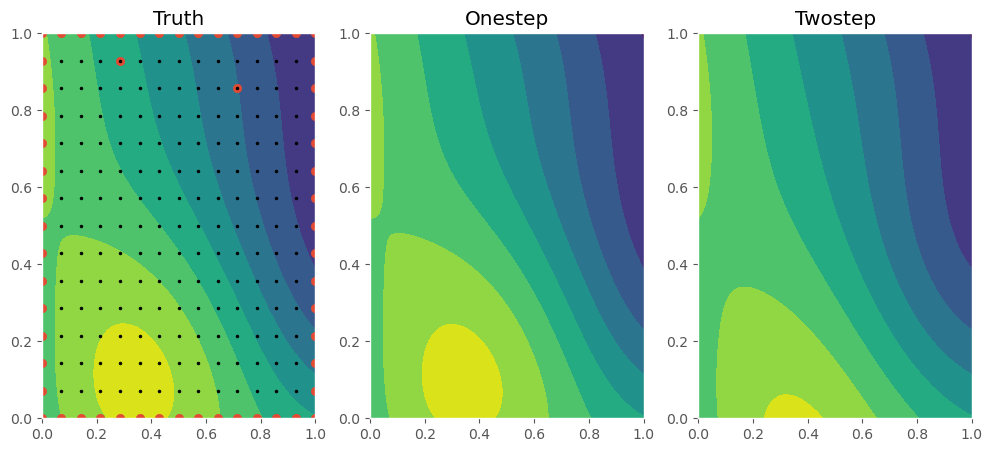

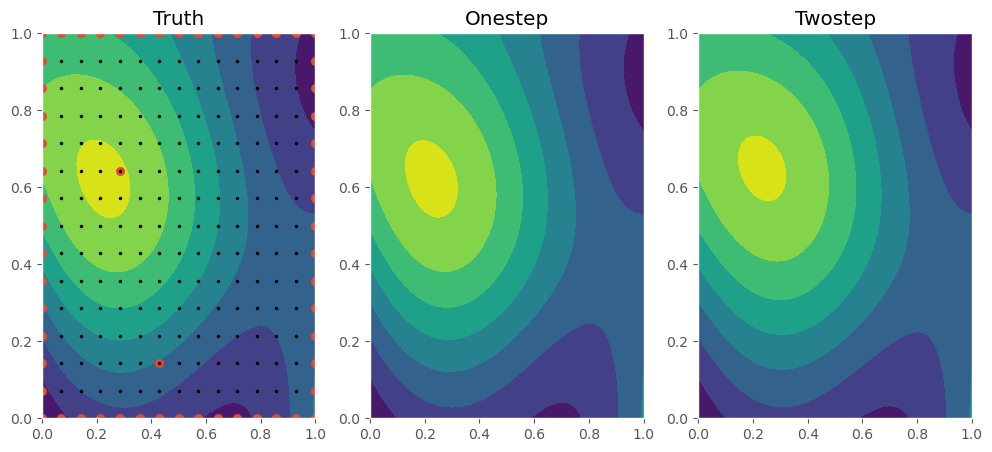

In [18]:
for i in range(m):
    xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))
    solution_index = i
    true_func_vals = jax.vmap(u_true_functions[solution_index])(xy_fine)
    onestep_vals = u_model.point_evaluate(xy_fine,u_sol[solution_index])
    interpolant_vals = u_model.point_evaluate(xy_fine,u_init[solution_index])
    # print("1step NRMSE: ",get_nrmse(true_func_vals,onestep_vals),"interpolant NRMSE: ",get_nrmse(true_func_vals,interpolant_vals))
    if i<3:
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        
        plt.tricontourf(*xy_fine.T,true_func_vals)
        plt.scatter(*xy_obs[i].T)
        plt.scatter(*collocation_points[0].T,c='black',s = 4)
        plt.title("Truth")
        plt.subplot(1,3,2)
        plt.tricontourf(*xy_fine.T,onestep_vals)
        plt.title("Onestep")
        plt.subplot(1,3,3)
        plt.tricontourf(*xy_fine.T,interpolant_vals)
        plt.title("Twostep")
        plt.show()


In [ ]:
# Operator learning error 
def run_exp_opt_err(m,obs_pts,run):
    '''
    Computes operator learning error for 1 step and 2 step methods.

    Args:
        m (int): Number of functions.
        obs_pts (int): Number of observed points.
        run (int): seed.
    
    Returns:
        i_opt_1_5 (float): Error for Phat (1 step) for in-sample functions.
        i_opt_2 (float): Error for Phat (2 step) for in-sample functions.

    '''
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = 2024
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 10
    num_interior_points = 50

    # Sample collocation points for f using same uniform grid for every function
    xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
    xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(run)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)
    u_models = tuple([CholInducedRKHS(
        xy_all[i],
        u_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints


    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])
    
    grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])
    
    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
        

    # P object        
    P_model = InducedOperatorModel(grid_features_u_init,k_P)
    num_P_params = len(grid_features_u_init)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
        num_P_operator_params = num_P_params
    )

    ### Optimize LM - new

    # Initialize
    # rhs_values = tuple(rhs_func(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))
    
    # P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values))
    # params_init = jnp.hstack(list(all_u_params_init)+[P_init])
    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])
    
    
    # Optimizer hyperparameters
    optparams = LMParams(max_iter = 301,
                         line_search_increase_ratio = 1.4,
                         print_every = 100,
                         tol = 1e-10)
    # Run CholeskyLM 
    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        optParams = optparams
    )
    
    # p_adjusted,refine_convergence_data = SVD_LM(
    #     params,
    #     EqnModel,
    #     beta = 1e-13,
    #     optParams = optparams
    # )

    # Optimized parameters
    u_sols = EqnModel.get_u_params(params)
    P_sol = EqnModel.get_P_params(params)


    ### Errors loop

    # # Testing grid
    # num_fine_grid = 50
    # x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    # xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T
    
    # # S_train for 1.5 step method
    # # model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)
    # model_grid_features_all = jnp.vstack([EqnModel.single_eqn_features(u_model,u_params,eval_points) 
    #                                       for u_model,u_params,eval_points in zip(
    #                                         EqnModel.u_models,
    #                                         u_sols,
    #                                         EqnModel.collocation_points)])

    # # S_train for 2 step method
    # #init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    # init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_model,u_params,eval_points) 
    #                                       for u_model,u_params,eval_points in zip(
    #                                         EqnModel.u_models,
    #                                         all_u_params_init,
    #                                         EqnModel.collocation_points)])

    # Backward operator error
    
    # Simulate u
    M = 3

    kernel_GP = get_gaussianRBF(0.5) # Same regularity as training u's
    # Sample M training functions from GP(0,K)
    u_news_ = GP_sampler(num_samples = M,
                    X = xy_pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    u_news = tuple([jax.vmap(u_new_) for u_new_ in u_news_]) # vmap'ed
    f_news = tuple([jax.vmap(get_rhs_darcy(u_new_)) for u_new_ in u_news_]) #vmap'ed

    # 1_5 step

    # Collocation points where to solve for \hat P (u) = f_new
    #num_interior_points = 500
    num_interior_points = 256
    num_grid_points = 20
    # Sample collocation points for learning u
    xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
            num_functions = 1,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(24)
        )
    # Boundary pairs
    xy_bdy = xy_boundarys[0]
    # Interior pairs (where PDE is satisfied)
    xy_int = xy_interiors[0]
    # Union of xy_bdy
    xy_all = jnp.vstack([xy_int,xy_bdy])

    # u_new object
    u_model = CholInducedRKHS(
        xy_all,
        feature_operators,
        k_u
        )

    def get_u_pde_adj(u_new,f_new,method):
        
        @jit
        def get_pred_hatP(input_features):
            # Option 1 - when using P_model = OperatorModel()
            # return P_model.predict_new(input_features,model_grid_features_all,P_sol) - before
            return P_model.predict(input_features,P_sol) # basis points still grid_features_init (?)
                    
        @jit
        def get_pred_hatP2step(input_features):
            # init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
            init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_model,u_params,eval_points) 
                                          for u_model,u_params,eval_points in zip(
                                            EqnModel.u_models,
                                            all_u_params_init,
                                            EqnModel.collocation_points)])
            rhs_stacked = EqnModel.stacked_collocation_rhs
            P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked) # Compute only once
            return P_model.predict(input_features,P_params_naive)

        

        new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


        class PdeModel():

            datafit_weight = 50.

            @jit
            def get_grid_features(u_params):
                evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
                grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
                return jnp.hstack([xy_int,grid_features])
            
            @jit
            def get_grid_target(u_params):
                return f_new(xy_int)
            
            @jit
            def eval_obs_points(u_params):
                return u_model.point_evaluate(xy_bdy,u_params)
            
            @jit
            def datafit_residual(u_params):
                obs_preds = PdeModel.eval_obs_points(u_params)
                return new_obs - obs_preds
            
            @jit
            def equation_residual(u_params):
                P_features = PdeModel.get_grid_features(u_params)
                P_model_preds = jnp.where(method == 1, get_pred_hatP(P_features), get_pred_hatP2step(P_features))
                ugrid_target = PdeModel.get_grid_target(u_params)
                return (ugrid_target - P_model_preds)
            
            @jit
            def F(u_params):
                eqn_res = PdeModel.equation_residual(u_params)
                data_res = PdeModel.datafit_residual(u_params)
                return jnp.hstack([
                    PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                    eqn_res/jnp.sqrt(len(eqn_res))
                    ])
            
            jac = jit(jacrev(F))

            def loss(u_params):
                return jnp.linalg.norm(PdeModel.F(u_params))**2
            
            @jit
            def damping_matrix(u_params):
                return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        
        # Optimize
        new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

        # Optimizer hyperparameters
        optparams = LMParams(max_iter = 301,
                         line_search_increase_ratio = 1.4,
                         print_every = 100,
                         tol = 1e-10)
        
        u_params_pde, _ = CholeskyLM(
            new_u_init.copy(),
            PdeModel,
            beta = 0,
            optParams = optparams
        )

        # u_params_pde,_ = CholeskyLM(
        #     new_u_init.copy(),
        #     PdeModel,
        #     beta = 0.,
        #     max_iter = 101,
        #     init_alpha=0.05,
        #     line_search_increase_ratio=1.4,
        #     print_every = 10
        # )

        # u_pde_adj,_ = SVD_LM(u_params_pde,PdeModel,1e-1,150)

    #     u_pde_adj,_ = SVD_LM(
    #     u_params_pde,
    #     EqnModel,
    #     beta = 1e-13,
    #     optParams = optparams
    # )

        return u_params_pde


    
    # Define fine grid to test
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
    xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    true = [u_new(xy_fine) for u_new in u_news]

    pred1_5 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=1))
        for u_new,f_new in zip(u_news,f_news)
    ]    

    pred2 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=2))
        for u_new,f_new in zip(u_news,f_news)
    ]

    i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_opt_1_5, i_opt_2


# Dictionary to store results
err = {
    '1_5_mthd': {
        '2_obs': {'i_opt': []},
        '4_obs': {'i_opt': []},
        '6_obs': {'i_opt': []},
        '8_obs': {'i_opt': []},
        '10_obs': {'i_opt': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_opt': []},
        '4_obs': {'i_opt': []},
        '6_obs': {'i_opt': []},
        '8_obs': {'i_opt': []},
        '10_obs': {'i_opt': []}
                }
}

# Run main loop
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,6,8,10]
for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_opt_1_5 = []
        i_opt_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp_opt_err(m, obs_pt, run)
            # Append
            i_opt_1_5.append(res[0])
            i_opt_2.append(res[1])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'].append(i_opt_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_opt'].append(i_opt_2)   
    # Save after
    jnp.save('errors', err)

print('success !')
